In [195]:
%matplotlib inline

import kb
import torch
import os
import csv
import numpy
import matplotlib.pyplot as plt
import argparse
from collections import defaultdict as dd
import pandas as pd

In [257]:
def get_entity_mid_name_type_rel_dict(model, dataset):
    mid_type=dd(str)
    mid_name=dd(str)
    name_mid=dd(str)
    dataset_root='./data/'+dataset+'/'
    with open("./data/"+dataset+"/entity_mid_name_type_typeid.txt") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            mid_type[row[0]] = row[2]
            mid_name[row[0]] = row[1]
   
    print(model.keys())
    if "entity_map" in model.keys(): 
        entity_map = model['entity_map']
    else:
        print("May have issues here!!")
        entity_map = get_maps(dataset_root)

    if 'reverse_entity_map' in model:
        reverse_entity_map = model['reverse_entity_map']
    else:
        reverse_entity_map = {}
        for k,v in entity_map.items():
            reverse_entity_map[v] = k   
    ktrain = kb.kb(os.path.join(dataset_root, 'train.txt'), em=entity_map, rem=reverse_entity_map, add_unknowns=True)

    return mid_name,name_mid,mid_type, ktrain.reverse_relation_map, entity_map, reverse_entity_map
    
def get_relation_type(train, mid_type)
    
def get_maps(dataset_root):
    ktrain = kb.kb(os.path.join(dataset_root, 'train.txt'))
    introduce_oov=1
    print("ALERT: introduce_oov", introduce_oov)

    if introduce_oov:
        if not "<OOV>" in ktrain.entity_map.keys():
            ktrain.entity_map["<OOV>"] = len(ktrain.entity_map)
            ktrain.nonoov_entity_count = ktrain.entity_map["<OOV>"]+1
    ktest = kb.kb(os.path.join(dataset_root, 'test.txt'), ktrain.entity_map, ktrain.relation_map,
                  add_unknowns=not introduce_oov, nonoov_entity_count=ktrain.nonoov_entity_count)
    kvalid = kb.kb(os.path.join(dataset_root, 'valid.txt'), ktrain.entity_map, ktrain.relation_map,
                   add_unknowns=not introduce_oov, nonoov_entity_count=ktrain.nonoov_entity_count)

    return ktrain.entity_map

def save_translated_file(file_name="", model=None,data=None, dataset=None):
    mid_name,name_mid,mid_type,reverse_relation_map,entity_map, reverse_entity_map = get_entity_mid_name_type_rel_dict(model, dataset)
    mid_name["<OOV>"] = "<OOV>"
    mid_type["<OOV>"] = "<OOV>"
    reverse_entity_map[len(reverse_entity_map)] = "<OOV>"   
    print(len(mid_name))
    print(len(mid_type))
    print(len(reverse_relation_map))
    print(len(entity_map))
    print(len(reverse_entity_map))
    all_data=dd(list)
    with open(file_name,"w") as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')    
        csv_writer.writerow(["r","e1","e2","e1_type","e2_type","e1P","e2P","e1P_type","e2P_type","e1Rank","e2Rank"])
        for r,e1,e2,e1p,e2p,e1r,e2r in data:
            csv_writer.writerow([reverse_relation_map[int(r)],mid_name[reverse_entity_map[int(e1)]],mid_name[reverse_entity_map[int(e2)]],mid_type[reverse_entity_map[int(e1)]],mid_type[reverse_entity_map[int(e2)]],mid_name[reverse_entity_map[int(e1p)]],mid_name[reverse_entity_map[int(e2p)]],mid_type[reverse_entity_map[int(e1p)]],mid_type[reverse_entity_map[int(e2p)]],e1r,e2r])
            all_data[(e1,r,e2)]=[reverse_relation_map[int(r)], mid_name[reverse_entity_map[int(e1)]],mid_name[reverse_entity_map[int(e2)]],mid_type[reverse_entity_map[int(e1)]],mid_type[reverse_entity_map[int(e2)]],mid_name[reverse_entity_map[int(e1p)]],mid_name[reverse_entity_map[int(e2p)]],mid_type[reverse_entity_map[int(e1p)]],mid_type[reverse_entity_map[int(e2p)]],e1r,e2r]
    return all_data

def save_both_file(model_data, file_name=""):
    with open(file_name,"w") as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')
        csv_writer.writerow(["r","e1","e2","e1_type","e2_type","e1P_typedM","e2P_typedM","e1P_typeM","e2P_typeM","e1Rank_typedM","e2Rank_typedM","e1P_imageM","e2P_imageM","e1P_type_imageM","e2P_type_imageM","e1Rank_imageM","e2Rank_imageM"])
        for e1,r,e2 in model_data["typed_model"].keys():
            csv_writer.writerow(model_data["typed_model"][(e1,r,e2)]+model_data["image_model"][(e1,r,e2)][5:])


def type_analysis(model_data,verbose=1):
    type_performance = {"image_model":dd(int),"typed_model":dd(int),"all_type":dd(int)}
    for tup in model_data["typed_model"].keys():
        r,e1,e2,e1_type,e2_type,e1P_typedM,e2P_typedM,e1P_typeM,e2P_typeM,e1Rank_typedM,e2Rank_typedM,e1P_imageM,e2P_imageM,e1P_type_imageM,e2P_type_imageM,e1Rank_imageM,e2Rank_imageM = model_data["typed_model"][tup]+model_data["image_model"][tup][5:]
        type_performance["all_type"][e1_type]+=1
        type_performance["all_type"][e2_type]+=1
        type_performance["image_model"][e1_type]+=int(e1_type==e1P_type_imageM)
        type_performance["image_model"][e2_type]+=int(e2_type==e2P_type_imageM)
        type_performance["typed_model"][e1_type]+=int(e1_type==e1P_typeM)  
        type_performance["typed_model"][e2_type]+=int(e2_type==e2P_typeM)
        
    for types in type_performance["all_type"].keys():
        type_performance["image_model"][types] = round(100.0*type_performance["image_model"][types]/type_performance["all_type"][types],2)
        type_performance["typed_model"][types] = round(100.0*type_performance["typed_model"][types]/type_performance["all_type"][types],2)
    
    if verbose>0:
        f1 = open("./analysis_yago/improved_types.csv",'w')
        f2 = open("./analysis_yago/deter_types.csv",'w')
        csv_writer1 = csv.writer(f1,delimiter=',')
        csv_writer2 = csv.writer(f2,delimiter=',')
        improved = [];deter = []
        for types in type_performance["all_type"].keys():
            diff = round(type_performance["image_model"][types] - type_performance["typed_model"][types],2)
            if diff> 10:
                improved.append((types,diff,type_performance["image_model"][types], type_performance["typed_model"][types] ,type_performance["all_type"][types]))
                csv_writer1.writerow([types,diff,type_performance["image_model"][types], type_performance["typed_model"][types] ,type_performance["all_type"][types]])
            elif diff < -10:
                deter.append((types,diff,type_performance["image_model"][types], type_performance["typed_model"][types] ,type_performance["all_type"][types]))
                csv_writer2.writerow([types,diff,type_performance["image_model"][types], type_performance["typed_model"][types] ,type_performance["all_type"][types]])
        print(improved)
        print(deter)
        f1.close()
        f2.close()
    return type_performance

def rel_analysis(model_data,verbose=1):
    r_performance = {"image_model":dd(int),"typed_model":dd(int),"all":dd(int)}
    for tup in model_data["typed_model"].keys():
        r,e1,e2,e1_type,e2_type,e1P_typedM,e2P_typedM,e1P_typeM,e2P_typeM,e1Rank_typedM,e2Rank_typedM,e1P_imageM,e2P_imageM,e1P_type_imageM,e2P_type_imageM,e1Rank_imageM,e2Rank_imageM = model_data["typed_model"][tup]+model_data["image_model"][tup][5:]
        r_performance["all"][r]+=1
        s_t=int(e1_type==e1P_type_imageM)
        o_t=int(e2_type==e2P_type_imageM)
        r_performance["image_model"][r] += int(s_t and o_t)
        s_t=int(e1_type==e1P_typeM)
        o_t=int(e2_type==e2P_typeM)
        r_performance["typed_model"][r] += int(s_t and o_t)

    for r in r_performance["all"].keys():
        r_performance["image_model"][r] = round(100.0*r_performance["image_model"][r]/r_performance["all"][r],2)
        r_performance["typed_model"][r] = round(100.0*r_performance["typed_model"][r]/r_performance["all"][r],2)

    if verbose>0:
        f1 = open("./analysis_yago/improved_rels.csv",'w')
        f2 = open("./analysis_yago/deter_rels.csv",'w')
        csv_writer1 = csv.writer(f1,delimiter=',')
        csv_writer2 = csv.writer(f2,delimiter=',')
        improved = [];deter = []
        for r in r_performance["all"].keys():
            diff = round(r_performance["image_model"][r] - r_performance["typed_model"][r],2)
            if diff> 10:
                improved.append((r,diff,r_performance["image_model"][r], r_performance["typed_model"][r] ,r_performance["all"][r]))
                csv_writer1.writerow([r,diff,r_performance["image_model"][r], r_performance["typed_model"][r] ,r_performance["all"][r]])
            elif diff < -10:
                deter.append((r,diff,r_performance["image_model"][r], r_performance["typed_model"][r] ,r_performance["all"][r]))
                csv_writer2.writerow([r,diff,r_performance["image_model"][r], r_performance["typed_model"][r] ,r_performance["all"][r]])
        print("improved:")
        for ele in improved:
            print(ele)
        print("deter:")
        for ele in deter:
            print(ele)
        f1.close()
        f2.close()
    return r_performance

def ent_analysis(model_data,verbose=1):
    e_performance = {"image_model":dd(int),"typed_model":dd(int),"all":dd(int)}
    for tup in model_data["typed_model"].keys():
        r,e1,e2,e1_type,e2_type,e1P_typedM,e2P_typedM,e1P_typeM,e2P_typeM,e1Rank_typedM,e2Rank_typedM,e1P_imageM,e2P_imageM,e1P_type_imageM,e2P_type_imageM,e1Rank_imageM,e2Rank_imageM = model_data["typed_model"][tup]+model_data["image_model"][tup][5:]
        e1 = e1.replace(",",":")
        e2 = e2.replace(",",":")
        e_performance["all"][(e1,e1_type)]+=1
        e_performance["all"][(e2,e2_type)]+=1
        s_t=int(e1_type==e1P_type_imageM)
        o_t=int(e2_type==e2P_type_imageM)
        e_performance["image_model"][(e1,e1_type)] += s_t
        e_performance["image_model"][(e2,e2_type)] += o_t
        s_t=int(e1_type==e1P_typeM)
        o_t=int(e2_type==e2P_typeM)
        e_performance["typed_model"][(e1,e1_type)] += s_t
        e_performance["typed_model"][(e2,e2_type)] += o_t 

    for e in e_performance["all"].keys():
        e_performance["image_model"][e] = round(100.0*e_performance["image_model"][e]/e_performance["all"][e],2)
        e_performance["typed_model"][e] = round(100.0*e_performance["typed_model"][e]/e_performance["all"][e],2)

    if verbose>0:
        f1 = open("./analysis_yago/improved_ents.csv",'w')
        f2 = open("./analysis_yago/deter_ents.csv",'w')
        csv_writer1 = csv.writer(f1,delimiter=',')
        csv_writer2 = csv.writer(f2,delimiter=',')
        improved = [];deter = []
        for e in e_performance["all"].keys():
            diff = round(e_performance["image_model"][e] - e_performance["typed_model"][e],2)
            if diff> 10:
                improved.append((e,diff,e_performance["image_model"][e], e_performance["typed_model"][e] ,e_performance["all"][e]))
                csv_writer1.writerow([e,diff,e_performance["image_model"][e], e_performance["typed_model"][e] ,e_performance["all"][e]])
            elif diff < -10:
                deter.append((e,diff,e_performance["image_model"][e], e_performance["typed_model"][e] ,e_performance["all"][e]))
                csv_writer2.writerow([e,diff,e_performance["image_model"][e], e_performance["typed_model"][e] ,e_performance["all"][e]])
        print("improved:")
        for ele in improved:
            print(ele)
        print("**********************************************************************")
        print("deter:")
        for ele in deter:
            print(ele)
        f1.close()
        f2.close()
    return e_performance

def get_custom_dict_e():
    return {"freq":0, "out_degree":set(), "in_degree":set(), "e1_freq":0, "e2_freq":0}


def get_custom_dict_r():
    return {"freq":0, "out_degree":set(), "in_degree":set()}

def get_data_stats(model, dataset):
    _,name_mid,mid_type, _, _, _ = get_entity_mid_name_type_rel_dict(model, dataset)

    e_stats = dd(get_custom_dict_e)#{freq:0, out:set(), in:set(), e1_freq:0, e2_freq:0}
    type_stats = dd(get_custom_dict_e)
    r_stats = dd(get_custom_dict_r)#freq, out, in
    dataset_root='./data/'+dataset+'/'
    with open("./data/"+dataset+"/train.txt") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        for row in csv_reader:
            e1,r,e2 = row
            e_stats[e1]["freq"] += 1; e_stats[e1]["e1_freq"] += 1;
            e_stats[e1]["out_degree"].add(r);  
            e_stats[e2]["freq"] += 1; e_stats[e2]["e2_freq"] += 1;
            e_stats[e2]["in_degree"].add(r);    
            r_stats[r]["freq"] += 1
            r_stats[r]["in_degree"].add(e1); r_stats[r]["out_degree"].add(e2);             

            e1_type = mid_type[name_mid[e1]]; e2_type = mid_type[name_mid[e2]];
            type_stats[e1_type]["freq"] += 1; type_stats[e1_type]["e1_freq"] += 1;
            type_stats[e1_type]["out_degree"].add(r);
            type_stats[e2_type]["freq"] += 1; type_stats[e2_type]["e2_freq"] += 1;
            type_stats[e2_type]["in_degree"].add(r);

    for stats in [e_stats, r_stats, type_stats]: #CHECK!!
        for key in stats.keys():
            stats[key]["in_degree"] = len(stats[key]["in_degree"])
            stats[key]["out_degree"] = len(stats[key]["out_degree"])

    return e_stats, r_stats, type_stats

def get_list_dict():
    return dd(list)

def model_analysis(model_data, model, dataset, verbose=1):
    #e_stats, r_stats, type_stats =  get_data_stats(model, dataset)

    e_performance = dd(list); e1_performance = dd(list); e2_performance = dd(list)
    e_type_performance = dd(list); e1_type_performance = dd(list); e2_type_performance = dd(list)
    r_e1_performance = dd(list); r_e2_performance = dd(list); r_e_performance = dd(list);
    r_e1_sep_performance = dd(get_list_dict); r_e2_sep_performance = dd(get_list_dict); r_e_sep_performance = dd(get_list_dict);

    for tup in model_data.keys():
        r,e1,e2,e1_type,e2_type,e1P,e2P,e1P_type,e2P_type,e1Rank,e2Rank = model_data[tup]
        e1Rank = 1.0/(float(e1Rank)+0.0000001); e2Rank = 1.0/(float(e2Rank)+0.0000001)
        e_performance[e1].append(e1Rank); e1_performance[e1].append(e1Rank);
        e_performance[e2].append(e2Rank); e2_performance[e2].append(e2Rank);
    
        e_type_performance[e1_type].append(e1Rank); e1_type_performance[e1_type].append(e1Rank);
        e_type_performance[e2_type].append(e2Rank); e2_type_performance[e2_type].append(e2Rank);

        r_e1_performance[r].append(e1Rank); r_e_performance[r].append(e1Rank); 
        r_e2_performance[r].append(e2Rank); r_e_performance[r].append(e2Rank)
        
        r_e1_sep_performance[r][e1].append(e1Rank); r_e_sep_performance[r][e1].append(e1Rank); 
        r_e2_sep_performance[r][e2].append(e2Rank); r_e_sep_performance[r][e2].append(e2Rank)

    return e_performance, e1_performance, e2_performance, e_type_performance, e1_type_performance, e2_type_performance, r_e1_performance, r_e2_performance, r_e_performance, r_e1_sep_performance, r_e2_sep_performance, r_e_sep_performance 


In [10]:
dataset="yago"
model="CX"

In [258]:

path = './analysis/'
file_name="_analysis_r_e1e2_e1Predictede2Predicted_e1Ranke2Rank.csv"
model_file="_best_valid_model.pt"
models = []
#models=["image_model","typed_model"]
#models = ["CX_yago"]
models.append(model+"_"+dataset)

if not models:
    print("ERROR: No model to analyze")

all_model_data = {}
for model_name in models:
    saved_model = torch.load(path+model_name+model_file)
    with open(path+model_name+file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        tmp = save_translated_file(file_name=path+"readable_"+model_name+file_name,model=saved_model,data=csv_reader, dataset=dataset)
        all_model_data[model_name] = tmp
#save_both_file(model_data, file_name=path+"readable_both_"+model_name+file_name)

e_performance, e1_performance, e2_performance, e_type_performance, e1_type_performance, e2_type_performance, r_e1_performance, r_e2_performance, r_e_performance, r_e1_sep_performance, r_e2_sep_performance, r_e_sep_performance = model_analysis(all_model_data[model+"_"+dataset], saved_model, dataset, verbose=1) 


dict_keys(['mini_batches', 'epoch', 'model_name', 'model_weights', 'optimizer_state', 'optimizer_name', 'valid_score_e2', 'test_score_e2', 'valid_score_e1', 'test_score_e1', 'valid_score_m', 'test_score_m'])
May have issues here!!
ALERT: introduce_oov 1
123144
123144
37
123144
123145


In [236]:
e_stats, r_stats, type_stats =  get_data_stats(saved_model, dataset)

dict_keys(['mini_batches', 'epoch', 'model_name', 'model_weights', 'optimizer_state', 'optimizer_name', 'valid_score_e2', 'test_score_e2', 'valid_score_e1', 'test_score_e1', 'valid_score_m', 'test_score_m'])
May have issues here!!
ALERT: introduce_oov 1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                          freq        inv_rank       num_instances       index
                          mean count      mean count          mean count      
bin                                                                           
(-1, 100]            19.787982  6490  0.453526  6490           0.0  6490     0
(100, 200]          143.606474   587  0.760116   587           0.0   587     1
(200, 300]          246.899390   328  0.838045   328           0.0   328     2
(300, 400]          346.220588   204  0.858692   204           0.0   204     3
(400, 500]          449.831461    89  0.904054    89           0.0    89     4
(500, 600]          543.423077    52  0.890631    52           0.0    52     5
(600, 700]          649.981481    54  0.858919    54           0.0    54     6
(700, 800]          744.593750    32  0.885286    32           0.0    32     7
(800, 900]          857.838710    31  0.899835    31           0.0    31     8
(900, 1000]         947.818182    22  0.923725    22

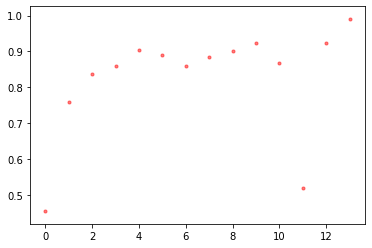

In [237]:
#entity analysis
x = [];y = [];y_freq=[]
for ele in e_performance:
    y.append(numpy.mean(e_performance[ele]))
    x.append(int(e_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,200,300,400,500,600,700,800,900,1000,5000,10000,50000,100000,200000,300000,400000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                      freq        inv_rank       num_instances       index
                      mean count      mean count          mean count      
bin                                                                       
(-1, 5]           3.117517   451  0.143004   451           0.0   451     0
(5, 10]           8.656731  1040  0.234195  1040           0.0  1040     1
(10, 15]         12.943975  1303  0.435250  1303           0.0  1303     2
(15, 20]         17.879365   945  0.581425   945           0.0   945     3
(20, 25]         22.799263   543  0.651219   543           0.0   543     4
(25, 30]         27.593220   236  0.745020   236           0.0   236     5
(30, 40]         34.429530   149  0.702582   149           0.0   149     6
(40, 50]         44.392857    28  0.578572    28           0.0    28     7
(50, 60]         56.375000    16  0.545482    16           0.0    16     8
(60, 70]         65.666667    12  0.198760    12           0.0    12     9
(70, 80]         75.00000

1884

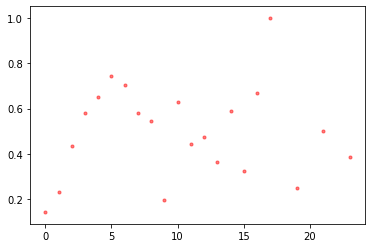

In [265]:
x = [];y = [];y_freq=[]
for ele in e1_performance:
    y.append(numpy.mean(e1_performance[ele]))
    x.append(int(e_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,5,10,15,20,25,30,40,50,60,70,80,90,100,150,200,300,400,500,600,700,800,900,1000,5000,70000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)
max(x)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                       freq        inv_rank       num_instances       index
                       mean count      mean count          mean count      
bin                                                                        
(-1, 5]            3.520958   167  0.203832   167             0   167     0
(5, 10]            7.985836   353  0.264284   353             0   353     1
(10, 15]          12.641350   237  0.377579   237             0   237     2
(15, 20]          17.943548   124  0.508774   124             0   124     3
(20, 25]          23.016949   118  0.571159   118             0   118     4
(25, 30]          28.148148    81  0.587677    81             0    81     5
(30, 40]          35.213793   145  0.620998   145             0   145     6
(40, 50]          45.349057   106  0.581279   106             0   106     7
(50, 60]          55.406977    86  0.666723    86             0    86     8
(60, 70]          65.765957    94  0.641855    94             0    94     9
(70, 80]    

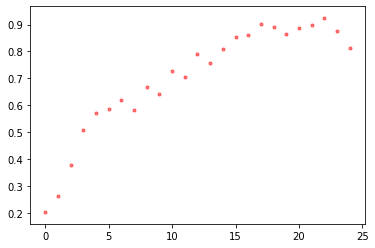

In [239]:
x = [];y = [];y_freq=[]
for ele in e2_performance:
    y.append(numpy.mean(e2_performance[ele]))
    x.append(int(e_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,5,10,15,20,25,30,40,50,60,70,80,90,100,150,200,300,400,500,600,700,800,900,1000,5000,70000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)

In [ ]:
#relation analysis from here

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                           freq        inv_rank       num_instances        \
                           mean count      mean count          mean count   
bin                                                                         
(-1, 100]                   NaN     0       NaN     0           NaN     0   
(100, 200]           109.000000     1  1.000000     1      1.000000     1   
(200, 300]           239.000000     1  0.112956     1      2.000000     1   
(300, 400]           393.000000     1  0.261111     1      1.000000     1   
(400, 500]                  NaN     0       NaN     0           NaN     0   
(500, 600]           555.000000     1  1.000000     1      1.000000     1   
(600, 700]                  NaN     0       NaN     0           NaN     0   
(700, 800]           726.000000     1  0.264813     1      2.000000     1   
(800, 900]                  NaN     0       NaN     0           NaN     0   
(900, 1000]          935.500000     2  0.081905     2      3.500000     2   

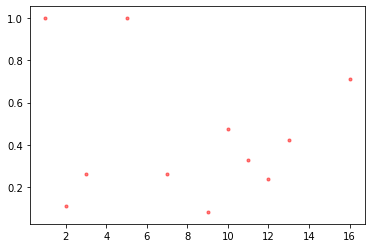

In [241]:
x = [];y = [];y_freq=[]
for ele in r_e_performance:
    y.append(numpy.mean(r_e_performance[ele]))
    x.append(int(r_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,200,300,400,500,600,700,800,900,1000,5000,10000,50000,100000,200000,300000,400000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)

In [209]:
r_stats

defaultdict(<function __main__.get_custom_dict_r()>,
            {'isLocatedIn': {'freq': 88672,
              'out_degree': 13272,
              'in_degree': 39689},
             'playsFor': {'freq': 321024,
              'out_degree': 8470,
              'in_degree': 45797},
             'isAffiliatedTo': {'freq': 373783,
              'out_degree': 10882,
              'in_degree': 48208},
             'diedIn': {'freq': 9248, 'out_degree': 1890, 'in_degree': 9248},
             'actedIn': {'freq': 32155, 'out_degree': 6754, 'in_degree': 5403},
             'graduatedFrom': {'freq': 7348,
              'out_degree': 1057,
              'in_degree': 4716},
             'wasBornIn': {'freq': 44978,
              'out_degree': 6081,
              'in_degree': 44978},
             'hasGender': {'freq': 66163, 'out_degree': 2, 'in_degree': 66163},
             'happenedIn': {'freq': 5056,
              'out_degree': 1368,
              'in_degree': 871},
             'hasMusicalRole': {'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                           freq        inv_rank       num_instances        \
                           mean count      mean count          mean count   
bin                                                                         
(-1, 100]                   NaN     0       NaN     0           NaN     0   
(100, 200]           109.000000     1  1.000000     1      1.000000     1   
(200, 300]           239.000000     1  0.009246     1      2.000000     1   
(300, 400]           393.000000     1  0.022222     1      1.000000     1   
(400, 500]                  NaN     0       NaN     0           NaN     0   
(500, 600]           555.000000     1  1.000000     1      1.000000     1   
(600, 700]                  NaN     0       NaN     0           NaN     0   
(700, 800]           726.000000     1  0.501792     1      2.000000     1   
(800, 900]                  NaN     0       NaN     0           NaN     0   
(900, 1000]          935.500000     2  0.104332     2      3.500000     2   

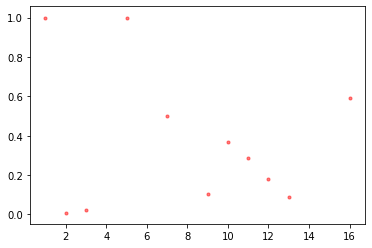

In [242]:
x = [];y = [];y_freq=[]
for ele in r_e1_performance:
    y.append(numpy.mean(r_e1_performance[ele]))
    x.append(int(r_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,200,300,400,500,600,700,800,900,1000,5000,10000,50000,100000,200000,300000,400000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                        freq        inv_rank       num_instances       index
                        mean count      mean count          mean count      
bin                                                                         
(-1, 100]                NaN     0       NaN     0           NaN     0     0
(100, 500]        224.285714     7  0.482322     7      3.857143     7     1
(500, 1000]       741.750000     4  0.288893     4     12.500000     4     2
(1000, 2000]     1535.000000     6  0.298436     6     37.166667     6     3
(2000, 3000]     2518.200000     5  0.293464     5     27.600000     5     4
(3000, 4000]     3105.500000     2  0.510498     2     16.500000     2     5
(4000, 5000]     4716.000000     1  0.073914     1     42.000000     1     6
(5000, 10000]    7961.000000     3  0.083454     3     98.000000     3     7
(10000, 50000]  44668.000000     4  0.350355     4    970.500000     4     8
(50000, 70000]  66163.000000     1  0.005220     1    307.000000     1     9

66163

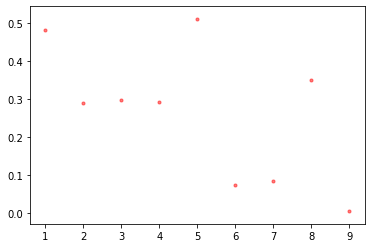

In [250]:
x = [];y = [];y_freq=[]
for ele in r_e1_performance:
    y.append(numpy.mean(r_e1_performance[ele]))
    x.append(int(r_stats[ele]["in_degree"]))
    y_freq.append(len(r_e1_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,500,1000,2000,3000,4000,5000,10000,50000,70000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)
max(x)

/home/prachi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/prachi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                           freq        inv_rank       num_instances        \
                           mean count      mean count          mean count   
bin                                                                         
(-1, 100]              0.000000  7927       NaN     0      0.000000  7927   
(100, 200]           109.000000     1  1.000000     1      1.000000     1   
(200, 300]           239.000000     1  0.216667     1      2.000000     1   
(300, 400]           393.000000     1  0.500000     1      1.000000     1   
(400, 500]                  NaN     0       NaN     0           NaN     0   
(500, 600]           555.000000     1  1.000000     1      1.000000     1   
(600, 700]                  NaN     0       NaN     0           NaN     0   
(700, 800]           726.000000     1  0.027834     1      2.000000     1   
(800, 900]                  NaN     0       NaN     0           NaN     0   
(900, 1000]          935.500000     2  0.059479     2      3.500000     2   

373783

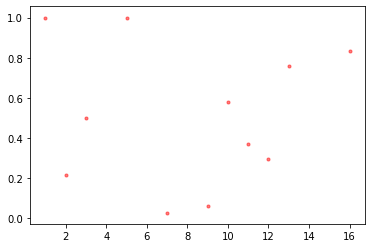

In [224]:
x = [];y = [];y_freq=[]
for ele in r_e2_performance:
    y.append(numpy.mean(r_e2_performance[ele]))
    x.append(int(r_stats[ele]["freq"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,200,300,400,500,600,700,800,900,1000,5000,10000,50000,100000,200000,300000,400000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)
max(x)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


                        freq        inv_rank       num_instances       index
                        mean count      mean count          mean count      
bin                                                                         
(-1, 100]          29.200000     5  0.638375     5     69.600000     5     0
(100, 500]        202.750000     4  0.762158     4      9.250000     4     1
(500, 1000]       671.166667     6  0.198934     6     10.833333     6     2
(1000, 2000]     1517.833333     6  0.471543     6     58.333333     6     3
(2000, 3000]     2785.000000     3  0.215604     3     25.333333     3     4
(3000, 4000]     3188.000000     1  1.000000     1     21.000000     1     5
(4000, 5000]     4704.000000     2  0.388285     2     21.500000     2     6
(5000, 10000]    6600.250000     4  0.347538     4    482.500000     4     7
(10000, 50000]  12077.000000     2  0.696471     2   1063.000000     2     8
(50000, 70000]           NaN     0       NaN     0           NaN     0     9

13272

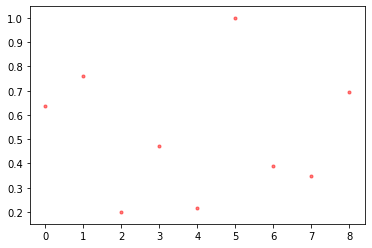

In [262]:
x = [];y = [];y_freq=[]
for ele in r_e2_performance:
    y.append(numpy.mean(r_e2_performance[ele]))
    x.append(int(r_stats[ele]["out_degree"]))
    y_freq.append(len(r_e2_performance[ele]))
    
df = pd.DataFrame({'freq':x, 'inv_rank':y, 'num_instances':y_freq})
bins=[-1,100,500,1000,2000,3000,4000,5000,10000,50000,70000]
interval=pd.cut(df["freq"], bins=bins)
df['bin'] = interval
df_plt = df.groupby('bin').agg(['mean', 'count'])#agg('mean')
df_plt['index'] = range(0, len(df_plt))
print(df_plt)
#plt.xlim(0,30)
plt.scatter(df_plt["index"],df_plt["inv_rank"]["mean"], s=area, c=colors, alpha=0.5)
max(x)

In [264]:
r_stats

defaultdict(<function __main__.get_custom_dict_r()>,
            {'isLocatedIn': {'freq': 88672,
              'out_degree': 13272,
              'in_degree': 39689},
             'playsFor': {'freq': 321024,
              'out_degree': 8470,
              'in_degree': 45797},
             'isAffiliatedTo': {'freq': 373783,
              'out_degree': 10882,
              'in_degree': 48208},
             'diedIn': {'freq': 9248, 'out_degree': 1890, 'in_degree': 9248},
             'actedIn': {'freq': 32155, 'out_degree': 6754, 'in_degree': 5403},
             'graduatedFrom': {'freq': 7348,
              'out_degree': 1057,
              'in_degree': 4716},
             'wasBornIn': {'freq': 44978,
              'out_degree': 6081,
              'in_degree': 44978},
             'hasGender': {'freq': 66163, 'out_degree': 2, 'in_degree': 66163},
             'happenedIn': {'freq': 5056,
              'out_degree': 1368,
              'in_degree': 871},
             'hasMusicalRole': {'